# 0.0. IMPORTS

In [1]:
import math
import datetime
import inflection
import warnings

import numpy               as np
import pandas              as pd
import seaborn             as sns
import matplotlib.gridspec as gridspec

from scipy      import stats as ss
from scipy      import stats
from tabulate   import tabulate
from matplotlib import pyplot as plt

from IPython.display       import Image
from IPython.core.display  import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings('ignore')

In [2]:
# Area de importacao de bibliotecas, cada biblioteca utilizada, vem para essa seccao.

## 0.1 Helper Functions

In [3]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1) ) )

In [4]:
# Funcoes utilizadas, ficam aqui por questao de organizacao.

## 0.2 Loading data

In [5]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
# Realizado loading dos arquivos CSV Sales e Store.
# Feito um merge para unir os dois em uma unica variavel no caso o df_raw, utilizando o Store como fenomeno base.

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

## 1.1. Rename Columns

In [7]:
df1 = df_raw.copy()

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

In [9]:
# Organizado a descricao do dados com underscore, que significa letras minusculas e palavras separadas por um underline

## 1.2. Data Dimensions


In [10]:
print('Number of rows:{}'.format(df1.shape[0]))
print('Number of cols:{}'.format(df1.shape[1]))

Number of rows:1017209
Number of cols:18


In [11]:
# Dimensao do conjunto de dados. Numero de linhas e numero de colunas

## 1.3. Data Types

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [13]:
#Tipos de dados, verificando o que object, inteiro e real, e tambem convertando data de objete para datetime[ns]

## 1.4 Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [15]:
# Realizada a checagem de dados faltantes

## 1.5 Fillout NA


In [16]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year      
df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week    
df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [17]:
# Realizando o preenchImento dos dados faltantes.
# competition_distance foi realizando um .max qual o valor maximo na variavel. O que estiver faltando sera preenchido com o valor maximo.
# competition_open_since_month e competition open since year, os dados faltantes foram preenchidos pelo date, ja que tinhamos essa informacao na planilha, tomando como base, que a data da abertura

## 1.6. Change Types


In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [19]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [20]:
# Central Tendency - mean, median
ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T
# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
df1

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",Jan,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4,2006,0,1,2013,0,Jan,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,1,2013,0,1,2013,0,Jan,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,1,2013,0,1,2013,0,Jan,0


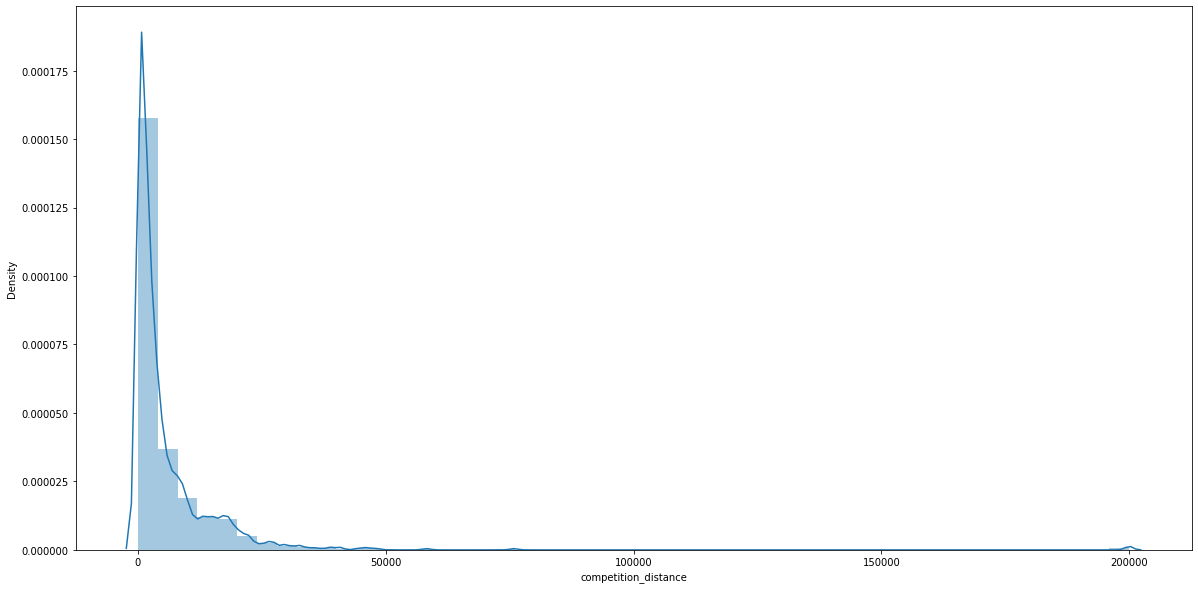

In [21]:
plt.figure(figsize=(20, 10))
sns.distplot( df1['competition_distance'] );

### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

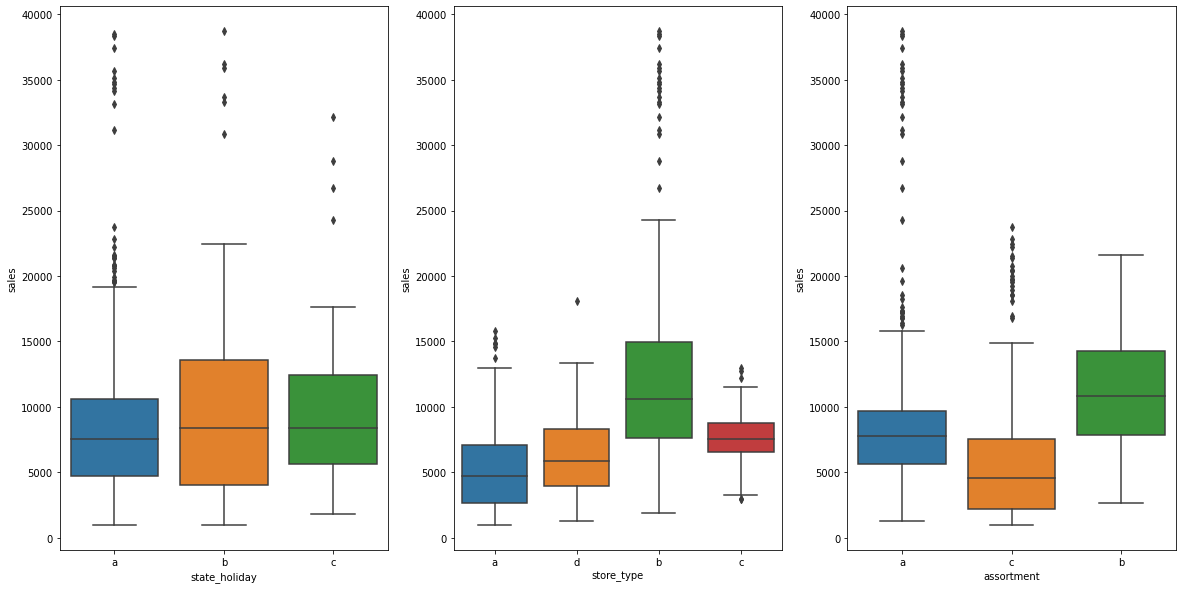

In [23]:
plt.figure(figsize=(20, 10))
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']  > 0)]

plt.subplot(1, 3, 1 )
sns.boxplot ( x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2 )
sns.boxplot ( x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3 )
sns.boxplot ( x='assortment', y='sales', data=aux1);

# 2.0. PASSO 02 - FEATURE ENGINEERING



In [24]:
df2 = df1.copy()

## 2.1. Mapa mental de hipoteses

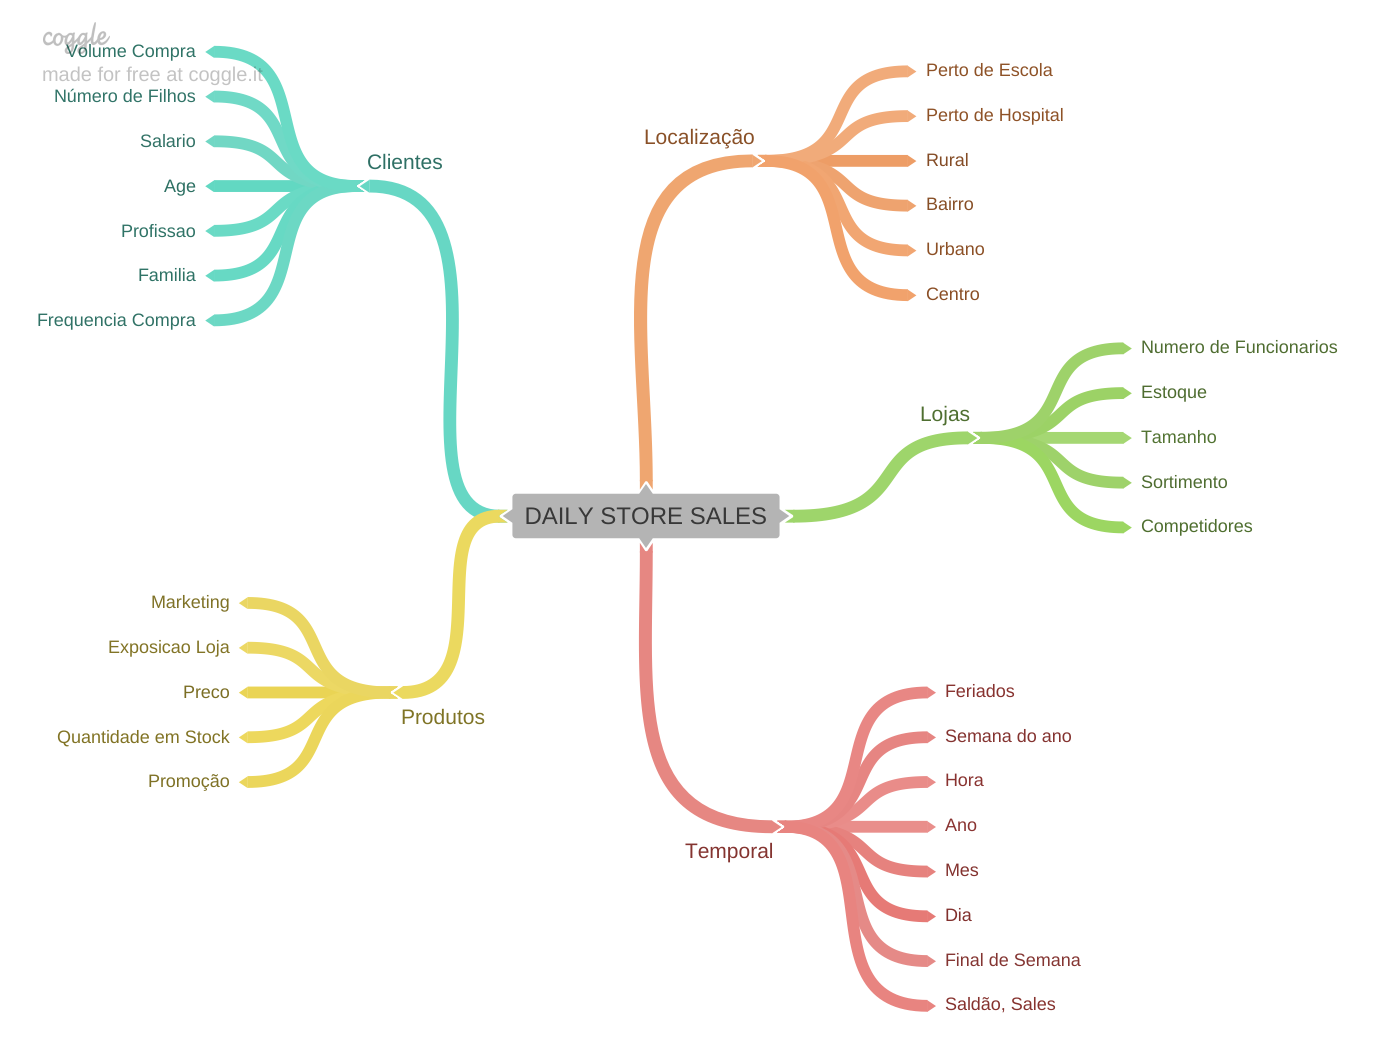

In [25]:
Image('../reports/figures/MindMapHypothesis.png')

## 2.2. Criacao de hipoteses

### 2.2.1. Hipoteses relacionadas a loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2. Hipoteses do Produto

**1.** Lojas que investem mais em marketing, deveriam vender mais.

**2.** Lojas com maior exposicao de produto deveriam vender mais.

**3.** Lojas com produtos com preco menor deveriam vender mais.

**4.** Lojas com promocoes mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.2.3. Hipoteses do Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.2. Lista final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas com mais promocoes consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.
 
**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3. Feature Engineering

In [26]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIAVEIS

In [28]:
df3 = df2.copy()

In [29]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das linhas 

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas 

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

In [32]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

##### * Objetivos 
    - Ganhar experiencia de Negocio
    - Validar Hipoteses de Negocio (Insights)
    - Perceber quais sao as variaveis que sao importantes para o Modelo.

In [33]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

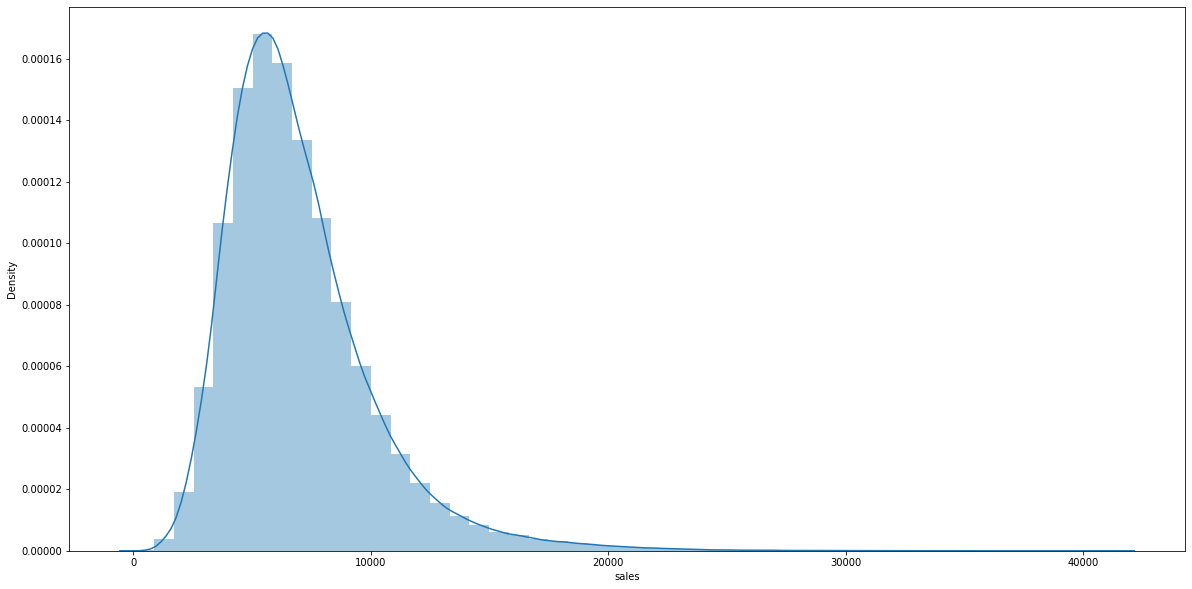

In [34]:
plt.figure(figsize=(20, 10))
sns.distplot(df4['sales']);

### 4.1.2. Numerical Variable

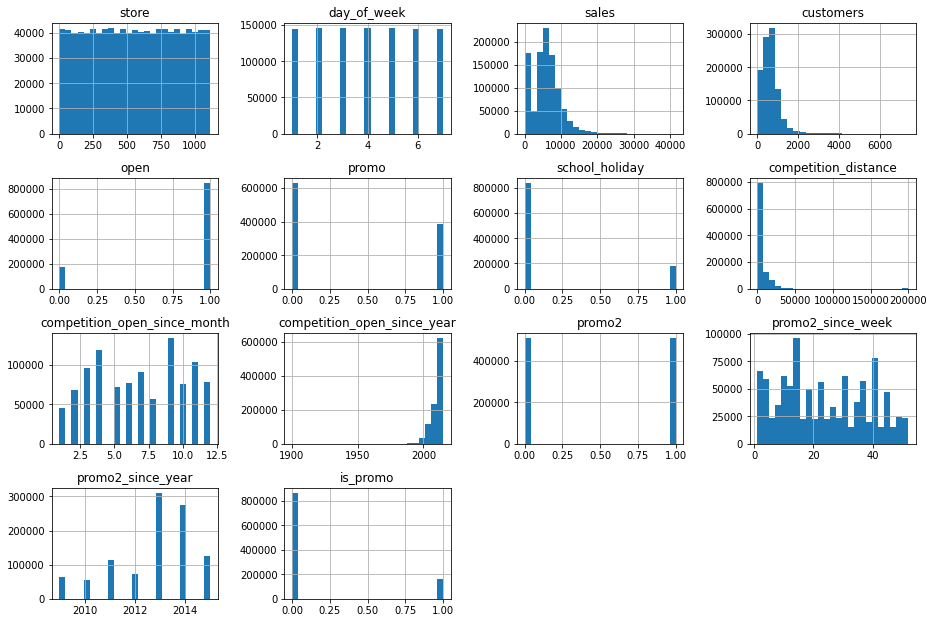

In [35]:
num_attributes.hist(bins=25, figsize=(15,10));
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

### 4.1.3. Categorical Variable

In [36]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

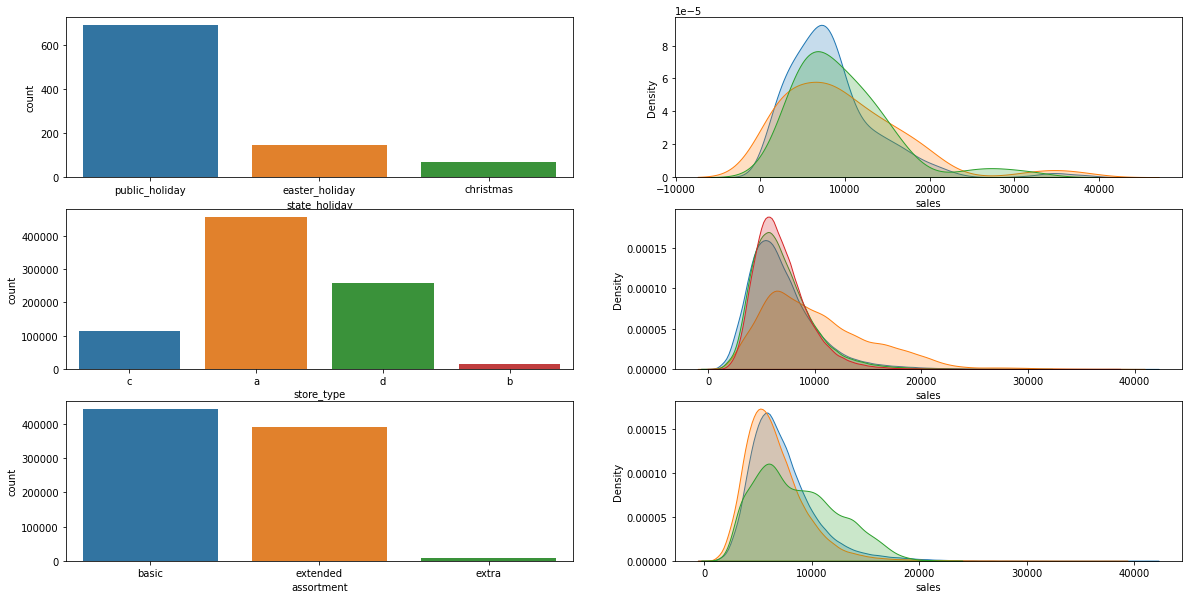

In [37]:
# state_holiday
plt.figure(figsize=(20, 10))

plt.subplot(3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2 )
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type

plt.subplot(3, 2, 3 )

sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4 )
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment

plt.subplot(3, 2, 5 )
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6 )

sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.

*** VERDADEIRA** Lojas com MAIOR SORTIMENTO vendem MAIS

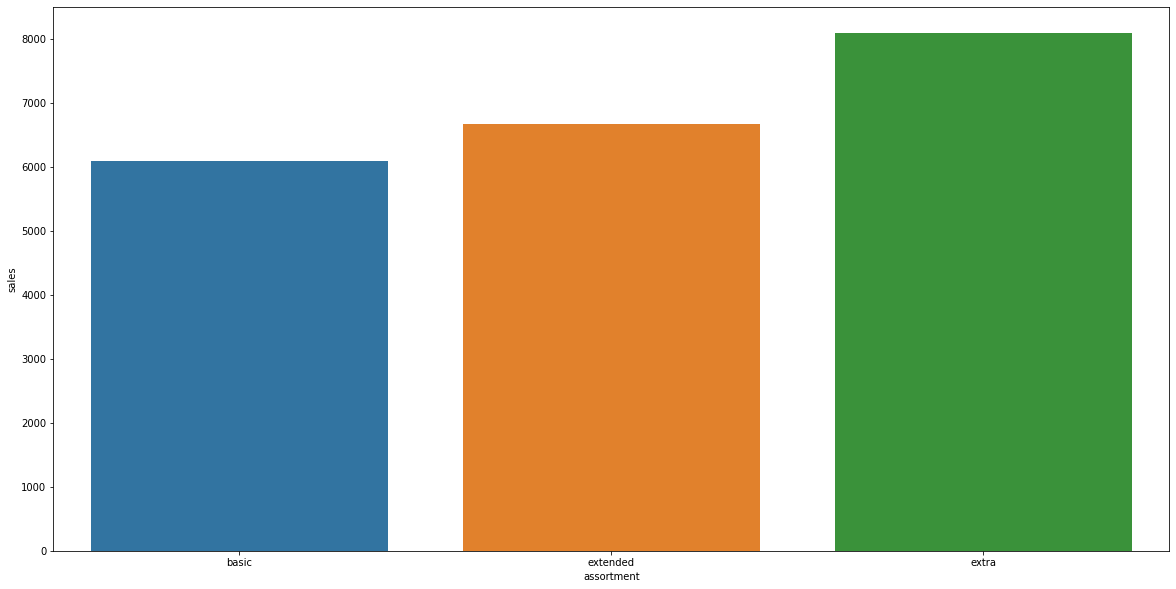

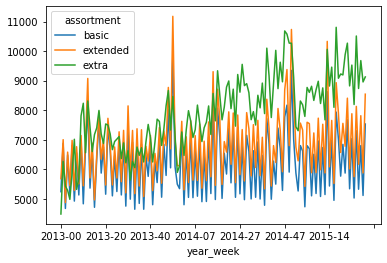

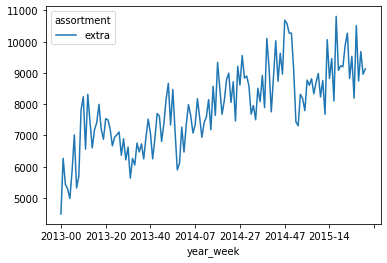

In [38]:
plt.figure(figsize=(20, 10))

aux1 = df4[['assortment', 'sales']].groupby('assortment').median().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).median().reset_index()
aux2.pivot( index='year_week' , columns='assortment' , values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week' , columns='assortment' , values='sales').plot();

### **H2.** Lojas com competidores mais proximos deveriam vender menos.

***FALSA** Lojas com COMPETIDORES mais PROXIMOS vendem MAIS}

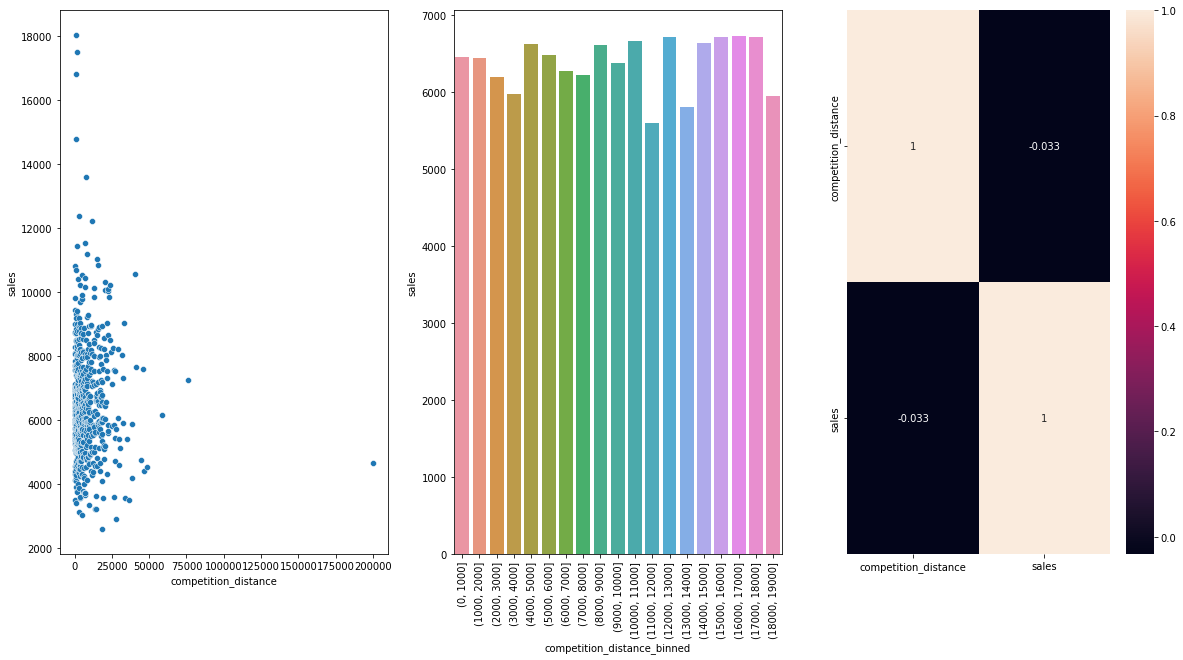

In [39]:
plt.figure(figsize=(20, 10))

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').median().reset_index()

plt.subplot(1, 3, 1 )
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2 )
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').median().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1, 3, 3 )
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **3.** Lojas com competidores a mais tempo deveriam vender mais.

***FALSA** Lojas com competidores a mais tempo vendem MENOS.

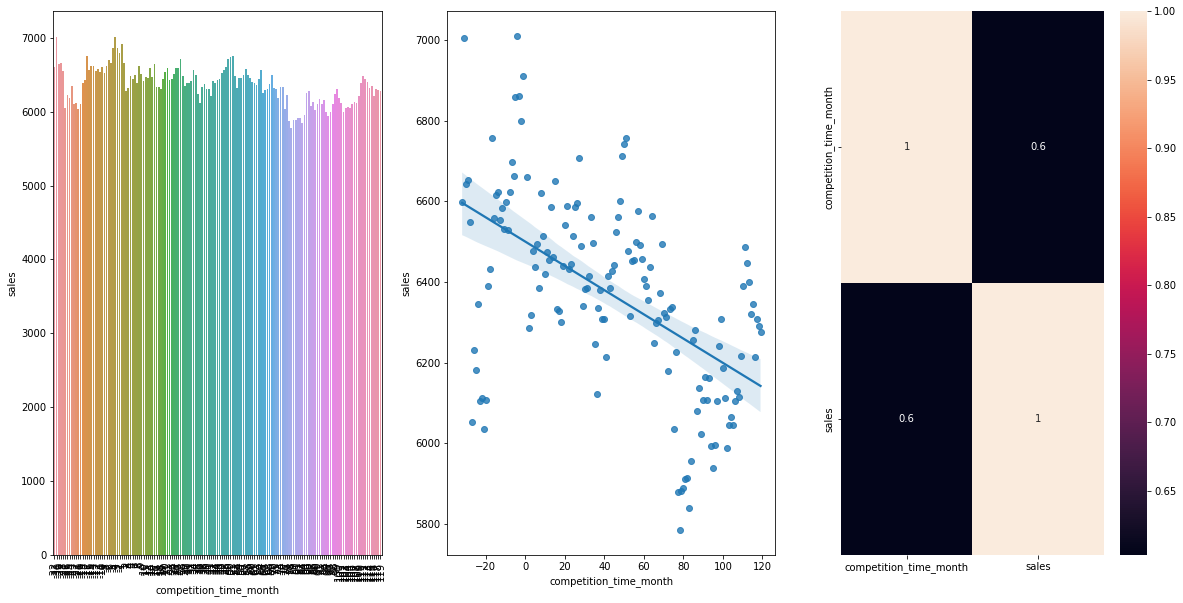

In [40]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').median().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

***Verdadeira** Lojas com promocoes ATIVAS por mais tempo VENDEM MAIS.

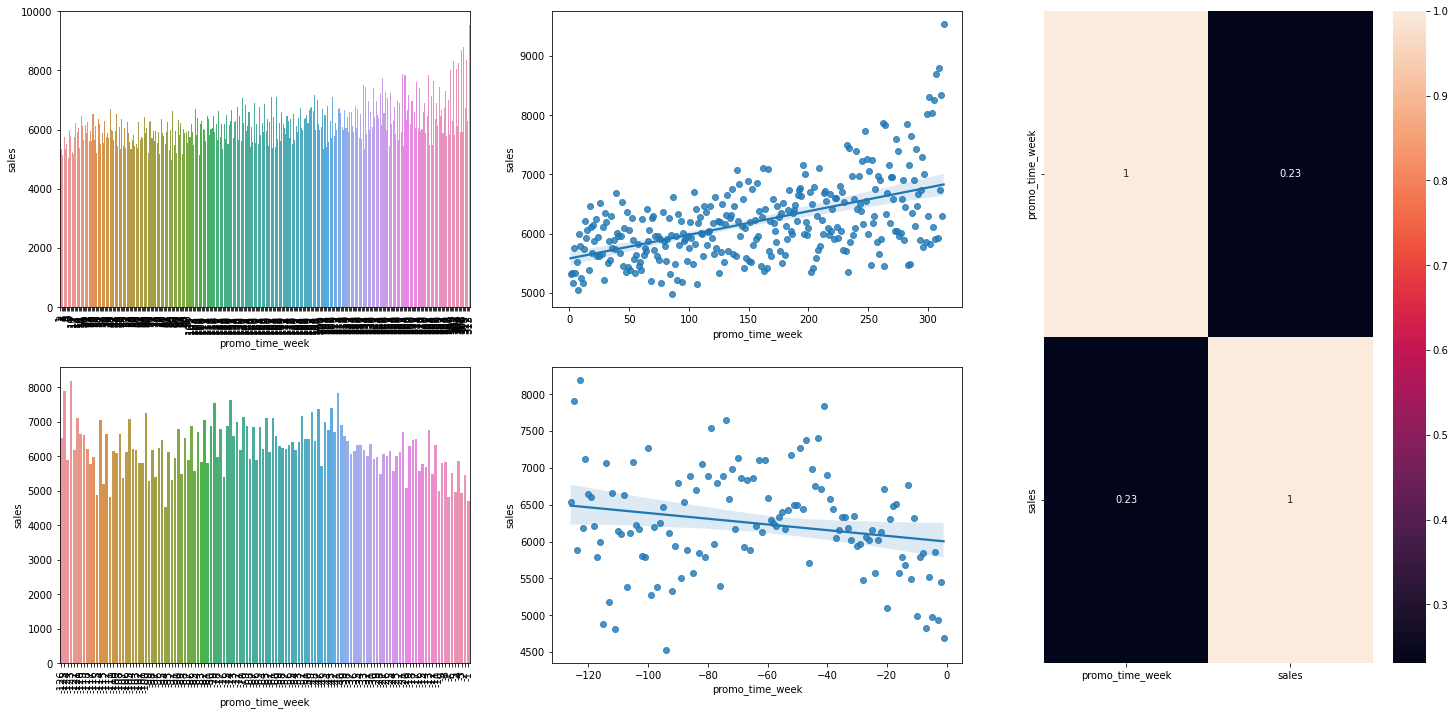

In [41]:
fig = plt.figure(figsize=(25, 12))
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').median().reset_index()

spec = gridspec.GridSpec(2, 3, figure=fig)

plt.subplot(spec[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extended
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(spec[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(spec[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(spec[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(spec[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>**5.** Lojas com mais dias de promocao deveriam vender mais.</s>

### **6.** Lojas com mais promocoes consecutivas deveriam vender mais.

***FALSA** Lojas com mais promocoes consecutivas vendem menos do que lojas que participam apenas da primeira promocao.

In [42]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).median().reset_index()

,promo,promo2,sales
0,0,0,5757.0
1,0,1,5181.0
2,1,0,7950.0
3,1,1,7358.0


<Figure size 1440x720 with 0 Axes>

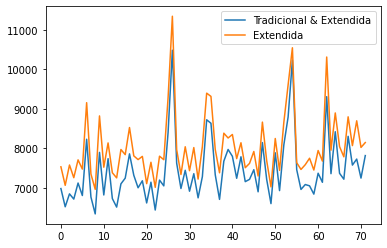

In [43]:
plt.figure(figsize=(20, 10))
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').median().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').median().reset_index()
aux2.plot(ax=ax)

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais


***VERDADE** Apesar de vender bem, o Natal ainda perde para a Pascoa.

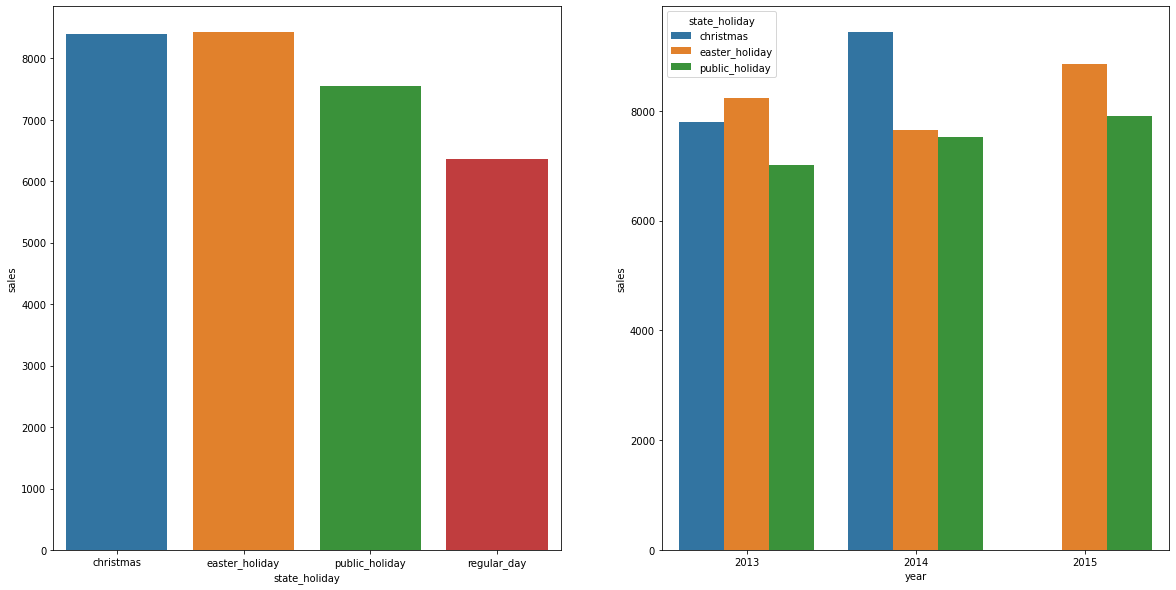

In [44]:
plt.figure(figsize=(20, 10))
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').median().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).median().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.

***Verdadeira** Ao longo dos anos a media de vendas vai aumentando

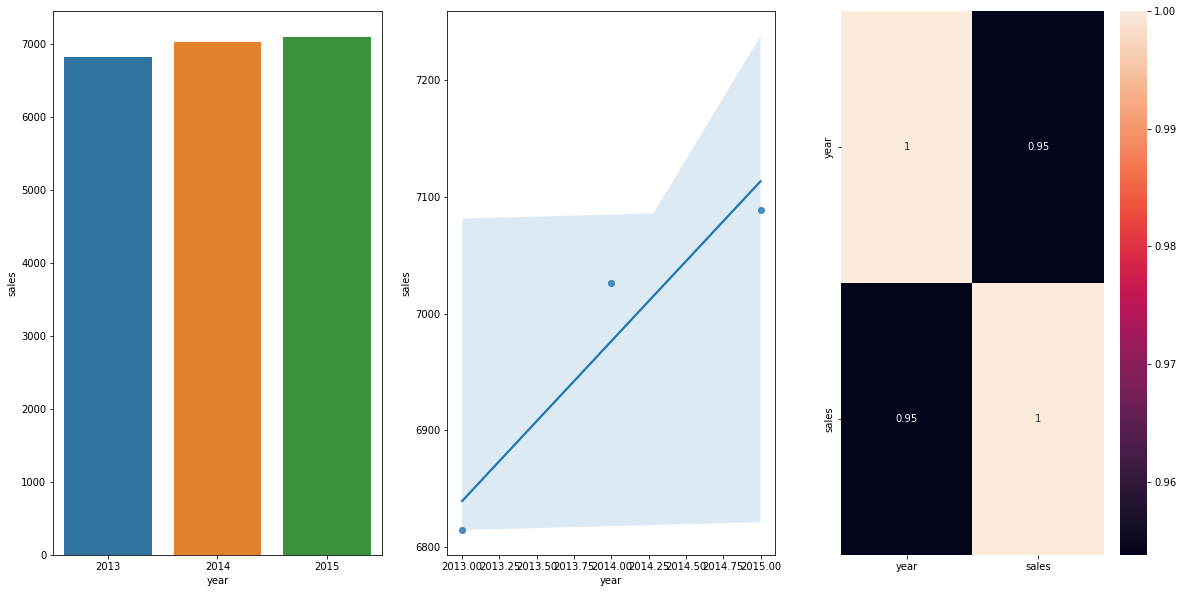

In [45]:
plt.figure(figsize=(20, 10))
aux1 = df4[['year', 'sales']].groupby('year').mean().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.

**VERDADEIRA** Lojas vendem mais no segundo semestre, principalmente no mes de Dezembro

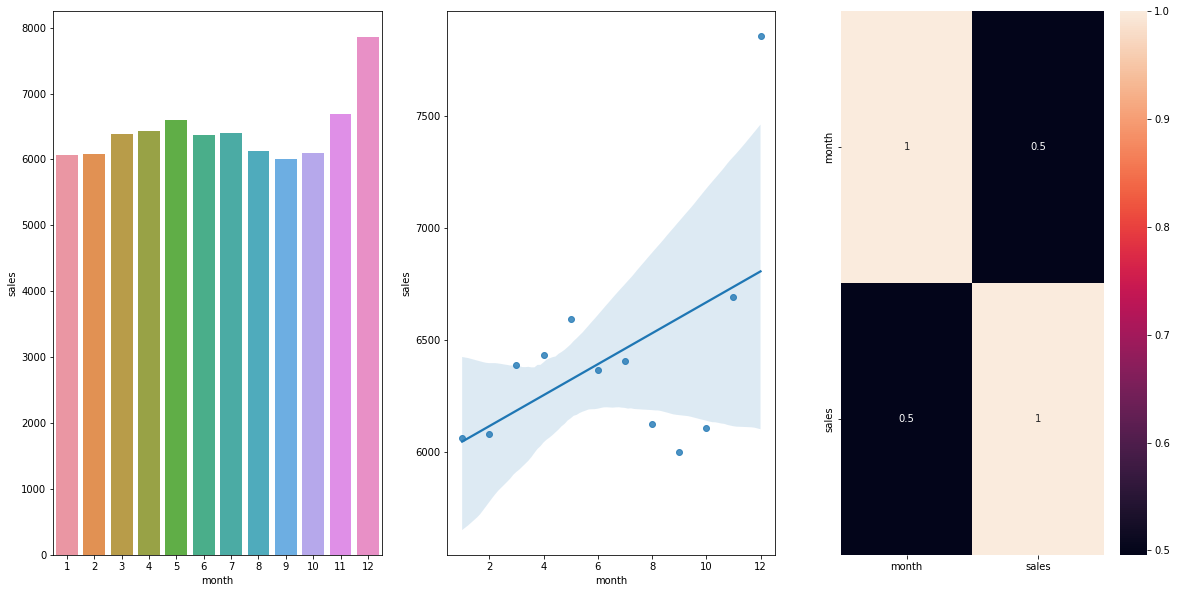

In [46]:
plt.figure(figsize=(20, 10))
aux1 = df4[['month', 'sales']].groupby('month').median().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**Falso** Lojas vendem mais antes do dia 10

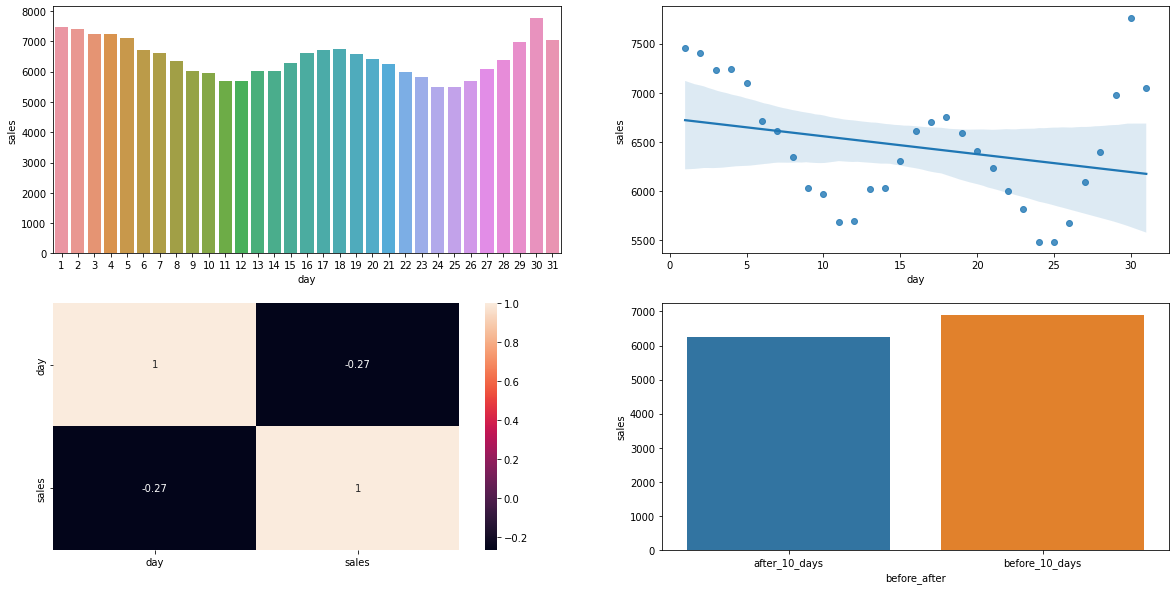

In [47]:
plt.figure(figsize=(20, 10))
aux1 = df4[['day', 'sales']].groupby('day').median().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days'if x <=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').median().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);


### **11.** Lojas deveriam vender menos aos finais de semana.

***Verdadeira** Lojas vendem menos nos finais de semana

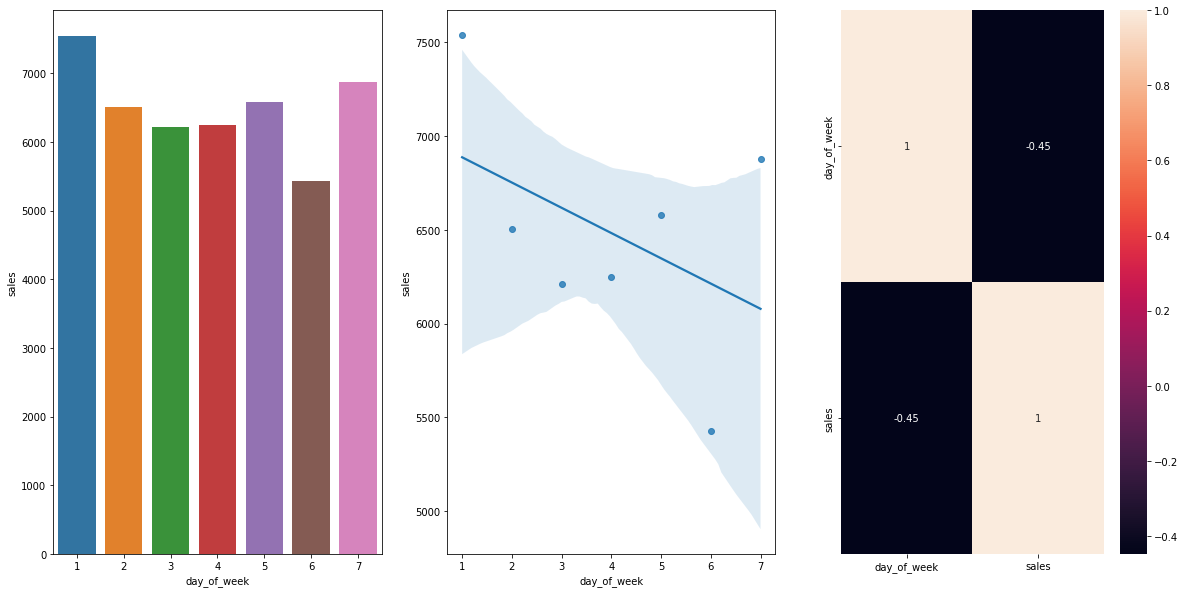

In [48]:
plt.figure(figsize=(20, 10))
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').median().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **12.** Lojas deveriam vender menos durante os feriados escolares.

***FALSA** Lojas vendem em media MAIS nos feriados escolares

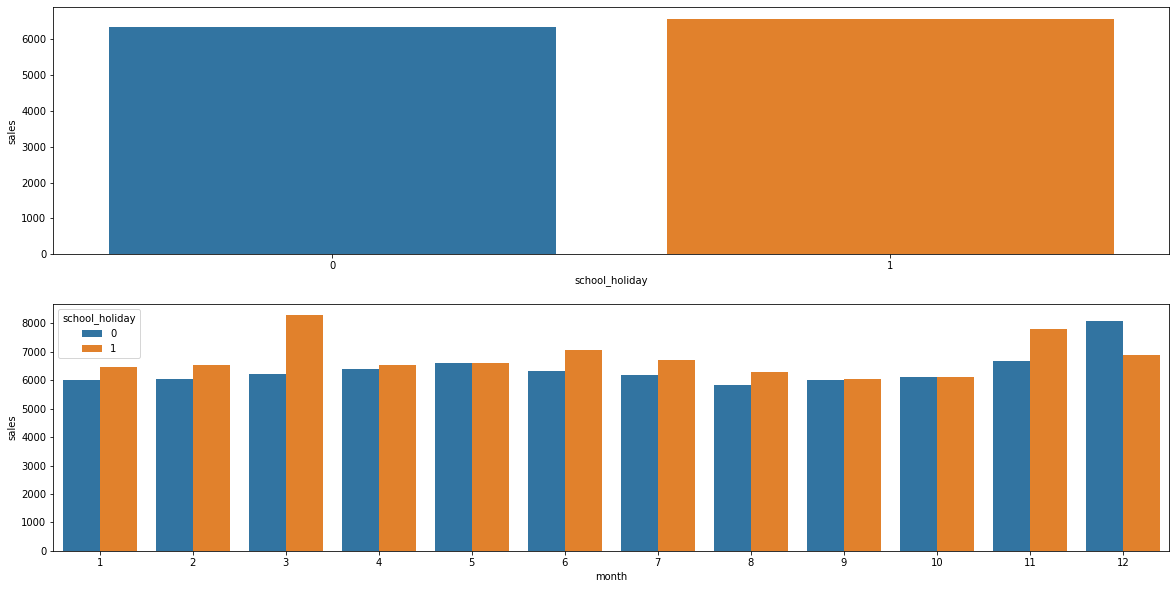

In [49]:
plt.figure(figsize=(20, 10))
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').median().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).median().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

In [50]:
tab = [['Hipoteses', 'Conlusao', 'Relevancia'],
       ['H1', 'VERDADEIRA', 'BAIXA'],
       ['H2', 'FALSA', 'MEDIA'],
       ['H3', 'FALSA', 'ALTA'],
       ['H4', 'VERDADEIRA', 'ALTA'],
       ['H5', '-----', '-----'],
       ['H6', 'FALSA', 'ALTA'],
       ['H7', 'VERDADEIRA', 'BAIXA'],
       ['H8', 'FALSA', 'BAIXA'],
       ['H9', 'VERDADEIRA', 'BAIXA'],
       ['H10', 'FALSA', 'VERDADEIRA'],
       ['H11', 'VERDADEIRA', 'BAIXA'],
       ['H12', 'FALSA', 'MEDIA'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conlusao    Relevancia
-----------  ----------  ------------
H1           VERDADEIRA  BAIXA
H2           FALSA       MEDIA
H3           FALSA       ALTA
H4           VERDADEIRA  ALTA
H5           -----       -----
H6           FALSA       ALTA
H7           VERDADEIRA  BAIXA
H8           FALSA       BAIXA
H9           VERDADEIRA  BAIXA
H10          FALSA       VERDADEIRA
H11          VERDADEIRA  BAIXA
H12          FALSA       MEDIA


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

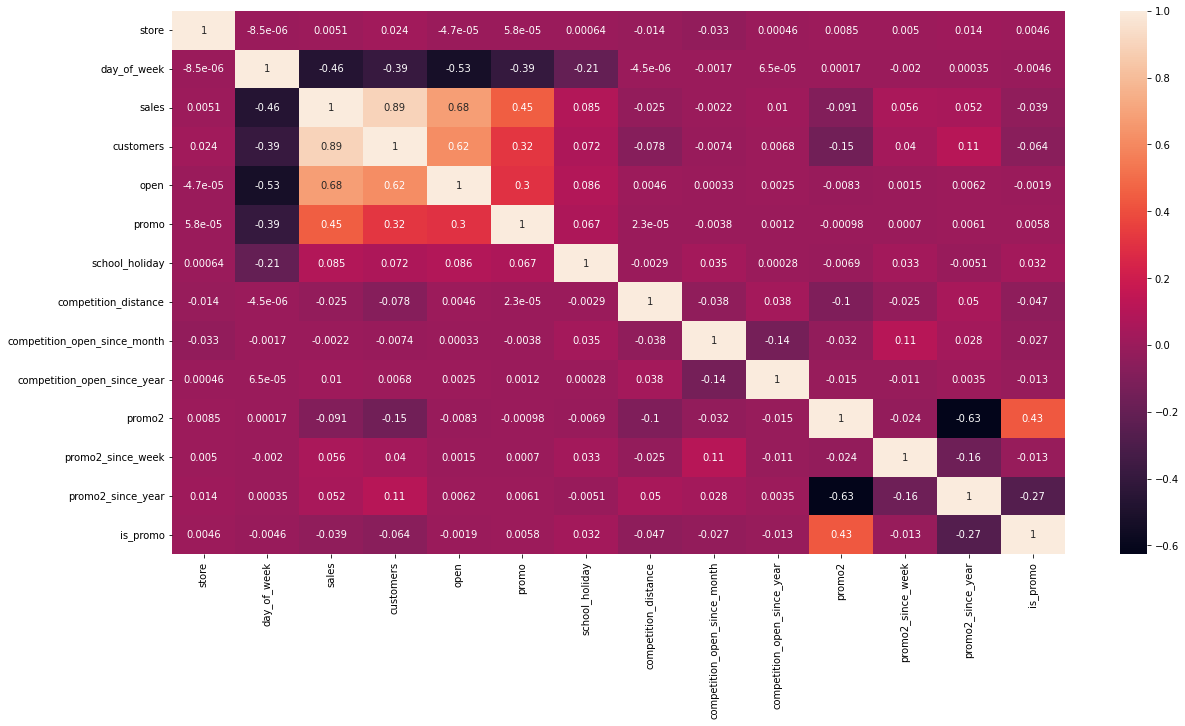

In [51]:
plt.figure(figsize=(20, 10))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.1. Categorical Attributes

In [52]:
# only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer_v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final data_set
d = pd.DataFrame({'state_holiday':[a1, a2, a3],
              'store_type':[a4, a5, a6],
              'assortment':[a7, a8, a9]})

d = d.set_index(d.columns);

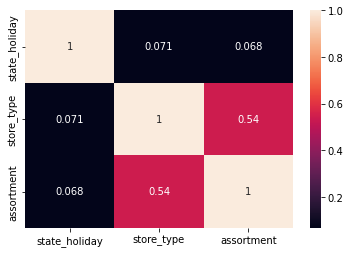

In [53]:
sns.heatmap(d, annot=True);

# 5.0. PASSO 05 - PREPARACAO DE DADOS

In [69]:
df5 = df4.copy()

## 5.1. Normalizacao

## 5.2. Rescaling

In [70]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

## 5.3. Transformacao

### 5.3.1. Encoding

In [71]:
# state_holiday - One Hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Nao tem como saber se tem uma ordem, so foi trocado as letras por numeros
# Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment = Ordinal Enconding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].replace(assortment_dict)

### 5.3.2. - Response Variable Transformation

In [72]:
# transformacao de variavel resposta por logarithm transformation

df5['sales'] = np.log1p(df5['sales'])

### 5.3.2. Nature Transformation

In [73]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [74]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2.* np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2.* np.pi/7) ) )

#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2.* np.pi/12) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2.* np.pi/12) ) )

#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2.* np.pi/30) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2.* np.pi/30) ) )

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2.* np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2.* np.pi/52) ) )

In [76]:
df5.sample(15)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
291128,618,1,2014-11-03,9.184920,1,0,3,3,1.222581,11,...,0,1,0.781831,0.623490,-5.000000e-01,8.660254e-01,5.877853e-01,0.809017,-0.748511,6.631227e-01
134198,399,4,2015-04-02,8.859931,1,1,0,1,0.488710,9,...,0,1,-0.433884,-0.900969,8.660254e-01,-5.000000e-01,4.067366e-01,0.913545,0.992709,-1.205367e-01
950276,1082,6,2013-03-02,9.006019,0,0,2,1,-0.304839,4,...,0,1,-0.781831,0.623490,1.000000e+00,6.123234e-17,4.067366e-01,0.913545,0.885456,4.647232e-01
740367,793,5,2013-09-06,8.083637,0,0,3,1,0.061290,7,...,0,1,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,9.510565e-01,0.309017,-0.935016,-3.546049e-01
375131,444,2,2014-08-05,9.517531,1,1,2,1,-0.101613,11,...,0,1,0.974928,-0.222521,-8.660254e-01,-5.000000e-01,8.660254e-01,0.500000,-0.663123,-7.485107e-01
458881,287,5,2014-05-16,8.799511,0,0,2,1,0.066129,5,...,0,1,-0.974928,-0.222521,5.000000e-01,-8.660254e-01,-2.079117e-01,-0.978148,0.663123,-7.485107e-01
4076,732,2,2015-07-28,9.333531,1,1,0,3,5.314516,7,...,0,1,0.974928,-0.222521,-5.000000e-01,-8.660254e-01,-4.067366e-01,0.913545,-0.568065,-8.229839e-01
329718,929,2,2014-09-23,8.432942,0,0,0,3,0.401613,9,...,0,1,0.974928,-0.222521,-1.000000e+00,-1.836970e-16,-9.945219e-01,0.104528,-1.000000,-1.836970e-16
459096,502,5,2014-05-16,9.111072,0,0,0,1,-0.340323,2,...,0,1,-0.974928,-0.222521,5.000000e-01,-8.660254e-01,-2.079117e-01,-0.978148,0.663123,-7.485107e-01
880459,395,5,2013-05-03,8.514991,1,0,0,1,0.208065,2,...,0,1,-0.974928,-0.222521,5.000000e-01,-8.660254e-01,5.877853e-01,0.809017,0.822984,-5.680647e-01
